# Explore

In [12]:
import os
from glob import glob
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

import cv2 

import skimage.io as io
from skimage import exposure
from skimage import util
from skimage.exposure import rescale_intensity,equalize_adapthist


In [5]:
INPUT="../data"
FOR_PRESENTATION="../results/for_presentation"

FileList=glob(os.path.join(INPUT,"*cut_region_corrected.tif"))

if len(FileList)>1:
    print("error: To many correctedBg files")

    
## Find File Prefix
head, tail = os.path.split(FileList[0])
FilePrefix=tail.split("_cutted_region.tiff")[0]
print(FileList[0],FilePrefix)

('../data/20200814 Maximes light settings_01 _C=0_cut_region_corrected.tif', '20200814 Maximes light settings_01 _C=0_cut_region_corrected.tif')


In [6]:
images=io.imread(FileList[0])
print(images.shape)
print(images.dtype)


(289, 1000, 1000)
uint16


## Median Intensity

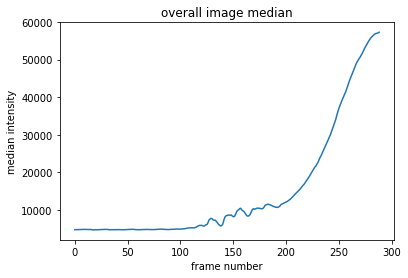

In [7]:
num_frame=images.shape[0]
output_list=[]
for i in range(num_frame):
    output_list.append({"frame":i,"img_median":np.median(images[i,:,:])})
    
Overall_median=pd.DataFrame(output_list)

plt.plot(Overall_median.frame,Overall_median.img_median)
plt.title("overall image median")
plt.xlabel("frame number")
plt.ylabel("median intensity")
plt.savefig(os.path.join(FOR_PRESENTATION,"overall_median_intensity.png"),bbox='tight')

<Figure size 1440x1440 with 0 Axes>

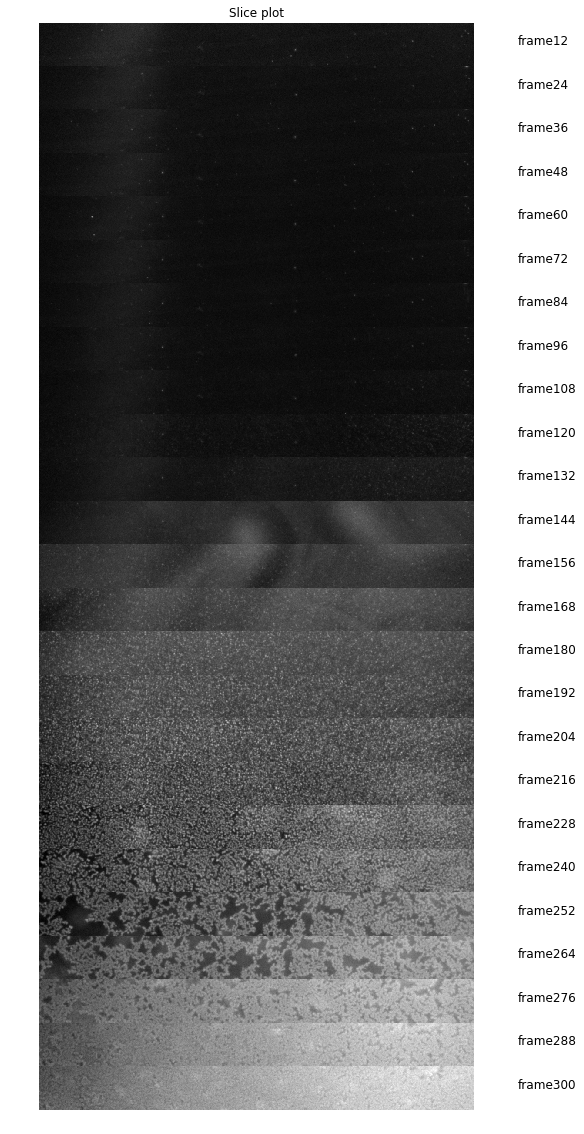

In [23]:
import sys
sys.path.append('../src')
from Intensity_measurements import Overall_intenstity,Plot_layer_time

def rescale_per_frame(img):
    vmin, vmax = np.percentile(img, q=(0.001, 99.9))
    #print(vmin, vmax)
    img_scaled = exposure.rescale_intensity(img,in_range=(vmin, vmax))
    return img_scaled


img_rescaled=np.zeros_like(images)
for frame in range(images.shape[0]):
    #print(frame)
    img_rescaled[frame,:,:] =rescale_per_frame(images[frame,:,:])
    
Plot_layer_time(img_rescaled,100,images.shape[1]/2,12,"Slice plot")
plt.savefig(os.path.join(FOR_PRESENTATION,"slice_plot_intensity_rescale.png"),bbox='tight')

<Figure size 1440x1440 with 0 Axes>

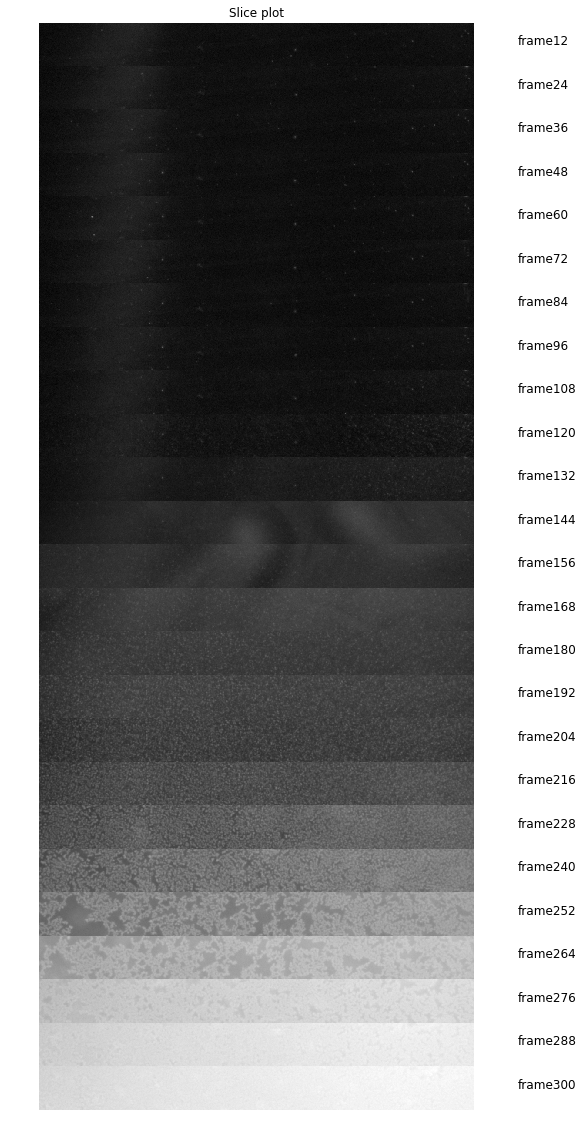

In [22]:

def gamma_correction(img):
    img_scaled = exposure.adjust_gamma(img,gamma=0.5)
    return img_scaled


img_rescaled=np.zeros_like(images)
for frame in range(images.shape[0]):
    #print(frame)
    img_rescaled[frame,:,:] =exposure.adjust_gamma(images[frame,:,:],gamma=0.5)
    
Plot_layer_time(img_rescaled,100,images.shape[1]/2,12,"Slice plot")
plt.savefig(os.path.join(FOR_PRESENTATION,"slice_plot_gamma.png"),bbox='tight')

## Clustering

### Local Binary pattern

In [24]:
from skimage.feature import local_binary_pattern
lbp =local_binary_pattern(image=images[77,:,:],P=8, R=1,method='default')


KeyboardInterrupt: 

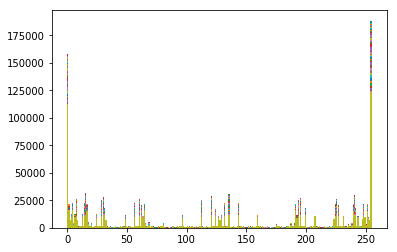

In [25]:
X=[]
for i in range(0,images.shape[0],1):
    lbp = local_binary_pattern(image=images[i,:,:], P=8, R=1,method='default')
    n,bins,patch =plt.hist(lbp.flatten(),bins=int(lbp.max()));
    X.append(n)
    #print(i)
    

In [26]:
i

268

## Compare histogrames
https://mpatacchiola.github.io/blog/2016/11/12/the-simplest-classifier-histogram-intersection.html

In [67]:
def return_intersection(hist_1, hist_2):
    minima = np.minimum(hist_1, hist_2)
    intersection = np.true_divide(np.sum(minima), np.sum(hist_2))
    return intersection

In [68]:
# Similarity matrix
SimilarityMatrix=np.zeros((len(X),len(X)))

for m in range(len(X)):
    for i in range(len(X)):
         SimilarityMatrix[m,i]=return_intersection(X[i], X[m])


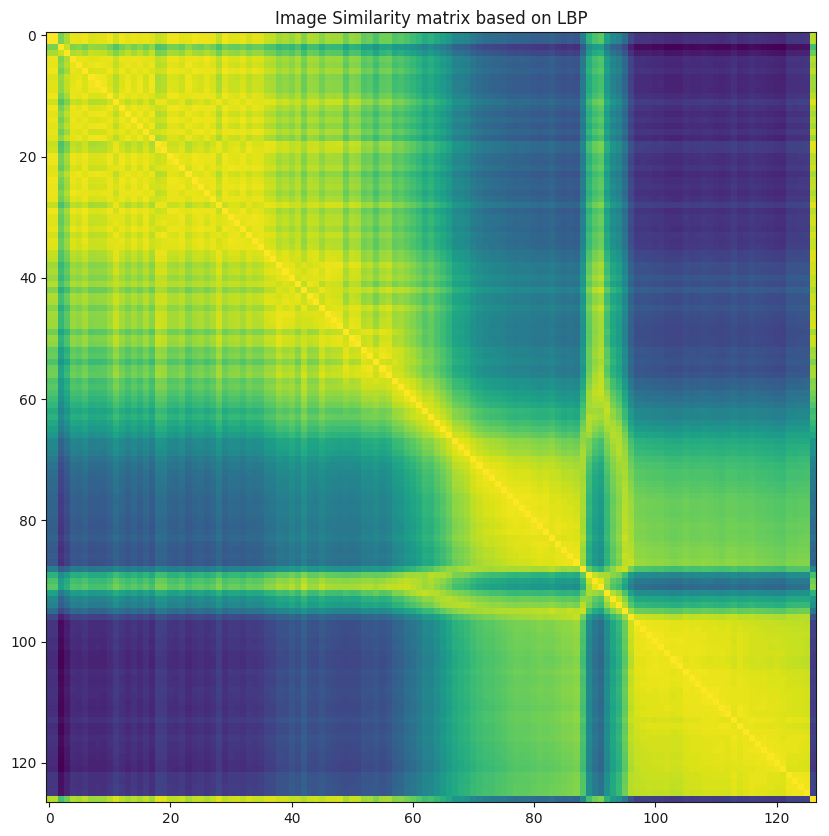

In [74]:
plt.style.use('default')
plt.figure(figsize=(10,10))
plt.imshow(SimilarityMatrix,cmap="viridis")
plt.title("Image Similarity matrix based on LBP")
plt.savefig(os.path.join(FOR_PRESENTATION,"Image_Similarity_matrix_based_on_LBP.png"),bbox='tight')

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score
from matplotlib import cm

n_clusters=3
kmeans=KMeans(n_clusters)
kmeans.fit(X)
y_kmeans = kmeans.predict(X)
centers = kmeans.cluster_centers_


ClusterResult=pd.DataFrame({"frame":range(0,images.shape[0]),"cluster":y_kmeans})


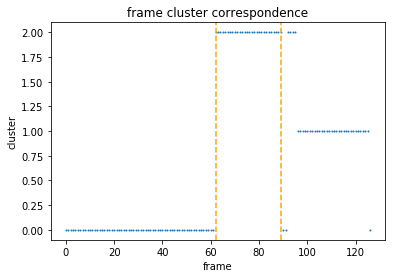

In [54]:
plt.scatter(ClusterResult.frame,ClusterResult.cluster,s=1)
plt.axvline(x=62,color='orange', linestyle='--')
plt.axvline(x=89,color='orange',linestyle='--')
plt.title("frame cluster correspondence")
plt.xlabel("frame")
plt.ylabel("cluster")
plt.savefig(os.path.join(FOR_PRESENTATION,"LBP_cluster.png"),bbox='tight')

In [15]:
# Sample image for each cluster

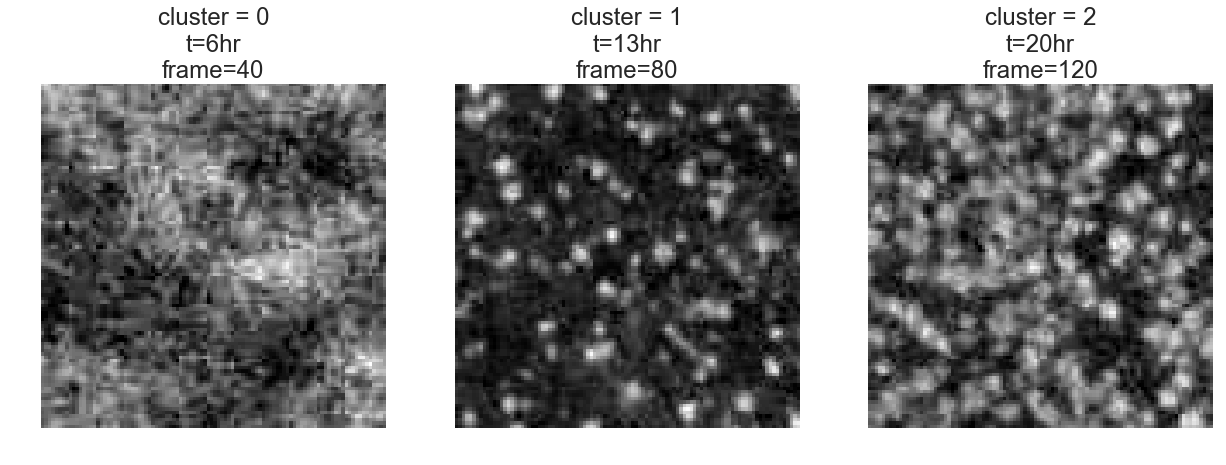

In [56]:
sns.set(font_scale=2)  
fig, ax = plt.subplots(1,3,figsize=(21,7))
#Time_list=[50,110,140,155]
Time_list=[40,80,120]

counter=0
for frame in Time_list:
    ll=100
    im_patch=images[frame,:ll,:ll]
    ax[counter].imshow(im_patch,cmap=plt.cm.gray)
    ax[counter].set_title("cluster = "+str(counter)+"\n"+"t="+str(frame*10/60)+"hr"+"\n"+"frame="+str(Time_list[counter]))
    ax[counter].axis('off')
    #print(frame,counter)
    counter=counter+1
    
plt.savefig(os.path.join(FOR_PRESENTATION,"LBP_cluster_viz.png"),bbox='tight')

In [ ]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score,adjusted_rand_score

In [ ]:
Start=ClusterResult.groupby("cluster")["frame"].min()
End=ClusterResult.groupby("cluster")["frame"].max()
Cluster=pd.concat([Start,End],axis=1)
Cluster.columns=["Start","End"]
Cluster=Cluster.sort_values(by="Start")
DataFor_Label=Cluster

fig=plt.figure(figsize=(7,7))
ax=fig.add_subplot(121)
viridis = cm.get_cmap('jet',n_clusters)
color_list=viridis(np.linspace(0, 1, n_clusters))

for k in Cluster.index:
    CoordCluster=X[y_kmeans==k, :]
    lab=str(DataFor_Label.loc[k].Start)+"-"+str(DataFor_Label.loc[k].End)+" hr"
    ax.scatter(CoordCluster[:, 0], CoordCluster[:, 1],c=color_list[k],s=15,cmap='viridis',label=lab)


scatter=ax.scatter(centers[:, 0], centers[:, 1], c='red',alpha=0.5);
plt.legend(title="cluster type")

ax.set_title("Kmeans clustering")
ax.set_xlabel("PCA component 1")
ax.set_ylabel("PCA component 2")
plt.legend()

plt.figure()
CC=ClusterResult.pivot_table(index="frame")
plt.plot(np.arange(0,images.shape[0]),CC.cluster+1)
plt.title("Image assing to the cluster")
plt.ylabel("cluster")
plt.xlabel("frame in hr")


## GLCM

In [10]:
## GLCM
from skimage.morphology.selem import rectangle
from skimage.feature import greycomatrix, greycoprops

Lag_distance=[i for i in range(1,20,3)]
Lag_angle=[0] #,np.pi/4,np.pi/2,3*np.pi/2
#print(Lag_distance,Lag_angle)

Texture_measurement=[]
for frame in range(images.shape[0]):
    #print(frame)
    gs=gaussian(images[frame,:,:], sigma=2)
    im_patch=gradient(gs,rectangle(3,3))
    #plt.figure()
    #plt.imshow(im_patch)
    for lag_dist in Lag_distance:
        for lag_angle in Lag_angle:
            glcm = greycomatrix(im_patch,distances=[lag_dist], angles=[lag_angle], levels=256,symmetric=True, normed=True)
        
            contr=greycoprops(glcm,'contrast')[0,0]
            Texture_measurement.append({"frame":frame,"lag_dist":lag_dist,"lag_angle":lag_angle,"contrast":contr})



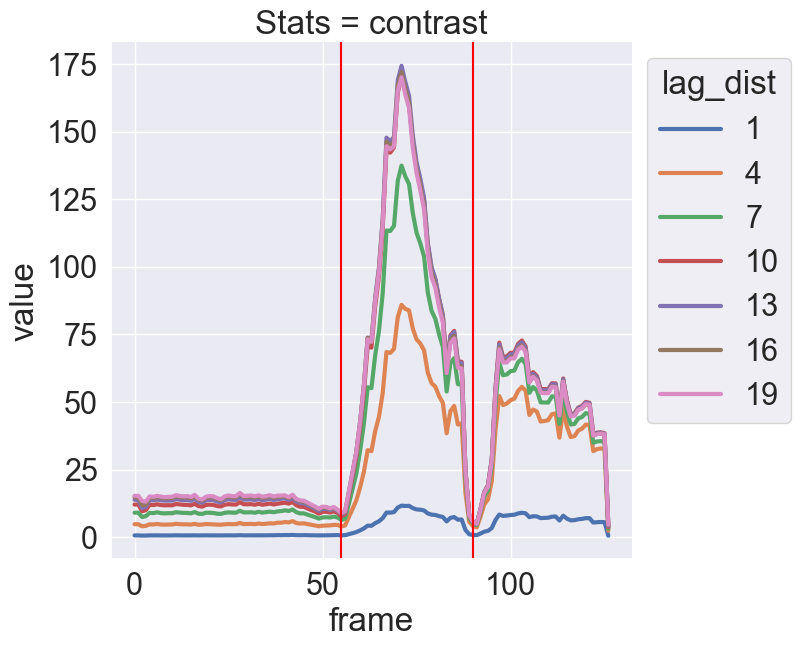

In [48]:
Texture_feature=pd.DataFrame(data=Texture_measurement,columns=['frame','lag_dist', 'lag_angle', 'contrast'])
Avaraged_angle=Texture_feature.groupby(["frame","lag_dist"]).mean().reset_index().drop(columns="lag_angle")
Melted_data_frame=pd.melt(Avaraged_angle,id_vars=['frame','lag_dist'],var_name='Stats')
sns.set_style('whitegrid')
sns.set(font_scale=2)  

g = sns.FacetGrid(Melted_data_frame, col="Stats",hue="lag_dist",sharex=False, sharey=False,height=7, aspect=1,legend_out=True,)
sns_plot=g.map(sns.lineplot,'frame','value',linewidth=3)
plt.legend(title="lag_dist",bbox_to_anchor=(1, 1), loc=2);
plt.axvline(x=55,color='red')
plt.axvline(x=90,color='red')
sns_plot.savefig("./for presentation/GLMC_contrast.png")

In [58]:
sns.set(font_scale=2)  
FrameSubset=Melted_data_frame[Melted_data_frame['frame'].isin(range(0,126,6))]
g = sns.FacetGrid(FrameSubset, col="Stats",hue="frame",sharex=False, sharey=False,height=7, aspect=1,legend_out=True,)
g.map(sns.lineplot,'lag_dist','value',linewidth=3)
plt.legend(title="frame",bbox_to_anchor=(1, 1), loc=2);
#plt.tight_layout()

NameError: name 'Melted_data_frame' is not defined